In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False

In [32]:
import webbpsf_ext
from webbpsf_ext.image_manip import fshift

In [4]:
# Initiate instrument class with selected filters, pupil mask, and image mask
inst = webbpsf_ext.MIRI_ext(filter='F1065C', pupil_mask='MASKFQPM', image_mask='FQPM1065')

[   webbpsf:INFO] MIRI SIAF aperture name updated to MIRIM_FULL
[   webbpsf:INFO] MIRI SIAF aperture name updated to MIRIM_CORON1065


In [5]:
# Calculate PSF coefficients
inst.gen_psf_coeff()
# Calculate position-dependent PSFs due to FQPM
inst.gen_wfemask_coeff()

[webbpsf_ext:INFO] Loading /Users/Jarron/NIRCam/webbpsf_ext_data/psf_coeffs/MIRI/F1065C_MASKFQPM_FQPM1065_pix128_os2_jsig0_r0.00_th+0.0_RevWslice0_legendre.fits
[webbpsf_ext:INFO] Loading /Users/Jarron/NIRCam/webbpsf_ext_data/psf_coeffs/MIRI/F1065C_MASKFQPM_FQPM1065_pix128_os2_jsig0_r0.00_th+0.0_RevWslice0_legendre_wfemask.npz


In [33]:
# Create a number of randomly positioned PSFs

apname = inst.aperturename # inst._psf_coeff_mod['si_mask_apname']
siaf_ap = inst.siaf[apname]

# Position relative to center of mask
xpos, ypos = (0,0)
xsci0, ysci0 = (xpos + siaf_ap.XSciRef, ypos + siaf_ap.YSciRef)

# Get offsets in sci coords
npsf = 10000
std_mas = 5
xoff_mas, yoff_mas = np.random.normal(loc=xpos, scale=std_mas, size=(2,npsf))

xsci = xoff_mas / (1000 * inst.pixelscale) + xsci0
ysci = yoff_mas / (1000 * inst.pixelscale) + ysci0

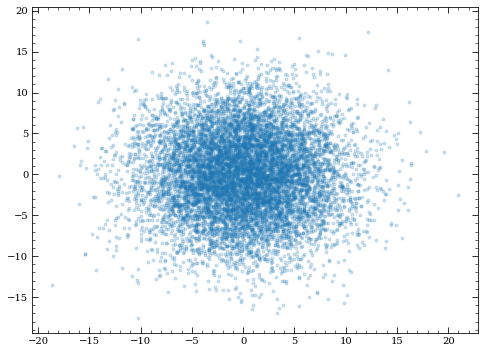

In [34]:
plt.plot(xoff_mas, yoff_mas, marker='.', ls='none', alpha=0.2)

In [24]:
nx = ny = inst.fov_pix*inst.oversample
psf_sum = np.zeros([ny,nx], dtype='float')

In [37]:
# Take average of all PSFs
nx = ny = inst.fov_pix*inst.oversample
psf_avg = np.zeros([ny,nx], dtype='float')
for i in trange(npsf):
    xv, yv = (xsci[i], ysci[i])
    hdul = inst.calc_psf_from_coeff(coord_vals=(xv, yv), coord_frame='sci', return_oversample=True)
    
    # Shift PSF relative to center
    dx, dy = np.array([xoff_mas[i], yoff_mas[i]]) / (1000 * hdul[0].header['PIXELSCL'])
    psf_avg += fshift(hdul[0].data, dx, dy)
    
    hdul.close()

# Take avareage
psf_avg /= npsf

  0%|          | 0/10000 [00:00<?, ?it/s]

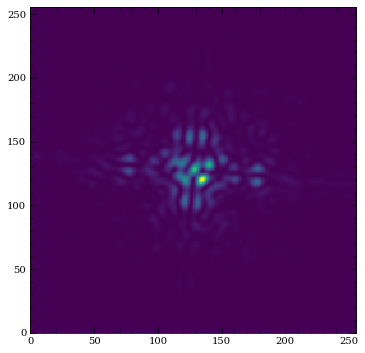

In [38]:
plt.imshow(psf_avg)

In [40]:
psf_avg = psf_sum

In [42]:
inst.options['jitter'] = 'gaussian'
inst.options['jitter_sigma'] = 0.005

In [43]:
# Calculate PSF coefficients
inst.gen_psf_coeff()

[webbpsf_ext:INFO] Generating and saving PSF coefficient


PSFs:   0%|          | 0/13 [00:00<?, ?it/s]

[webbpsf_ext:INFO] Took 15.03 seconds to generate WebbPSF images
[webbpsf_ext:INFO] Saving to /Users/Jarron/NIRCam/webbpsf_ext_data/psf_coeffs/MIRI/F1065C_MASKFQPM_FQPM1065_pix128_os2_jsig5_r0.00_th+0.0_RevWslice0_legendre.fits


In [55]:
hdul1 = inst.calc_psf_from_coeff(return_oversample=True)

In [56]:
from astropy.io import fits
from copy import deepcopy

In [57]:
hdul2 = deepcopy(hdul1)
hdul2[0].data = psf_avg

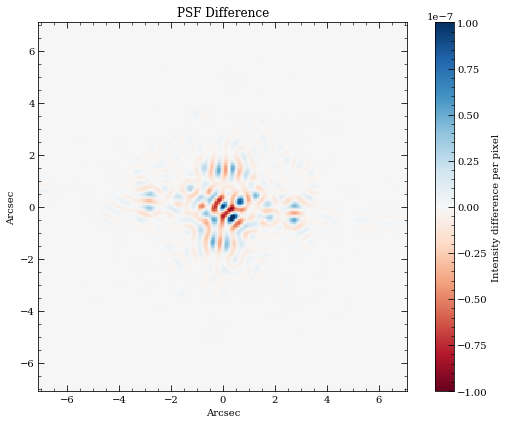

In [79]:
from webbpsf import display_psf_difference
fig, ax = plt.subplots(1,1)

psf_diff = hdul1[0].data - hdul2[0].data
vmin, vmax = 1e-7 * np.array([-1,1])

display_psf_difference(hdul1, hdul2, ax=ax, vmin=vmin, vmax=vmax, cmap='RdBu')

ax.set_title('PSF Difference')
ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')

fig.tight_layout()

In [65]:
psf_diff.min()

-9.308355670165972e-08